# Baseline Model – ElasticNet for Short-Range Wind Power Forecasting

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

## 1. Load and Prepare Dataset

In [22]:
df = pd.read_csv("../data/processed/wtb_features.csv")

# Sort by time for proper temporal split
df = df.sort_values("Timestamp")

In [23]:
target = 'Patv'
drop_cols = ['Patv', 'Timestamp', 'TurbID']
X = df.drop(columns=drop_cols)
y = df[target]

## 2. TimeSeries Split

In [24]:
tscv = TimeSeriesSplit(n_splits=10)

## 3. ElasticNet + GridSearchCV

In [25]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', ElasticNet(max_iter=10000))
])

In [26]:
param_grid = {
    'elasticnet__alpha': [0.1, 1.0, 10.0],
    'elasticnet__l1_ratio': [0.1, 0.5, 0.9]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

# Best model
y_pred = grid_search.predict(X)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


## 4. Model Evaluation

In [27]:
mae = mean_absolute_error(y, y_pred)
rmse = root_mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

In [28]:
print("ElasticNet Baseline Results")
print(f"Best Params: {grid_search.best_params_}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.3f}")

ElasticNet Baseline Results
Best Params: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.9}
MAE: 128.12
RMSE: 188.49
R^2: 0.810


### ElasticNet Baseline Results

A baseline regression model using ElasticNet was trained to perform short-range wind power forecasting (predicting the next 10-minute time-step of `Patv`). 

ElasticNet combines L1 and L2 regularization, allowing for both feature selection and shrinkage. The model was tuned using `GridSearchCV` with a `TimeSeriesSplit` cross-validation strategy to respect the temporal structure of the data.

**Best Hyperparameters**:
- `alpha = 0.1`
- `l1_ratio = 0.9`

**Performance Metrics**:
- **MAE**: 128.12 kW
- **RMSE**: 188.49 kW
- **R²**: 0.810

Given that `Patv` ranges from 0 to 1600 kW, the model achieves:

- A **mean absolute error (MAE)** of roughly **8% of the full range**, which is reasonably low for short-range forecasting on real turbine data.
- An **RMSE** of ~188 kW, meaning larger errors are still present, but not dominant.
- An **R² of 0.81**, indicating that 81% of the variance in power output is explained by the model.

These values suggest that the baseline model performs well overall, with relatively small average errors in the context of the turbine’s operating range. Considering this is a linear model without temporal or multi-step context, the result is a strong and interpretable starting point.

We now inspect the model coefficients to better understand which features were most influential in this prediction task.

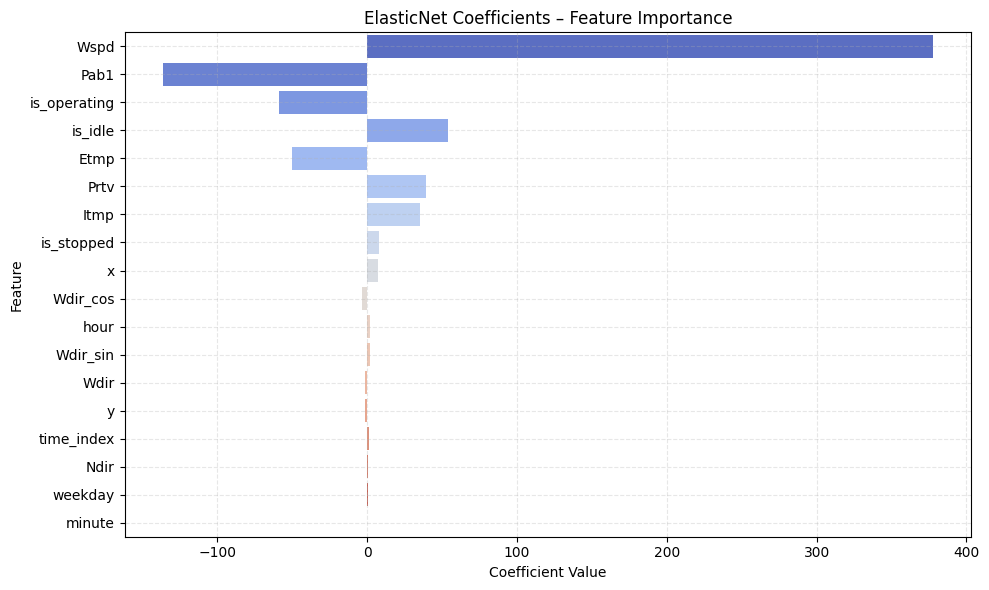

In [29]:
best_model = grid_search.best_estimator_.named_steps['elasticnet']

feature_names = X.columns

coefs = best_model.coef_

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=coef_df,
    hue='Feature',
    palette='coolwarm',
    dodge=False,
    legend=False
)
plt.title("ElasticNet Coefficients – Feature Importance")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

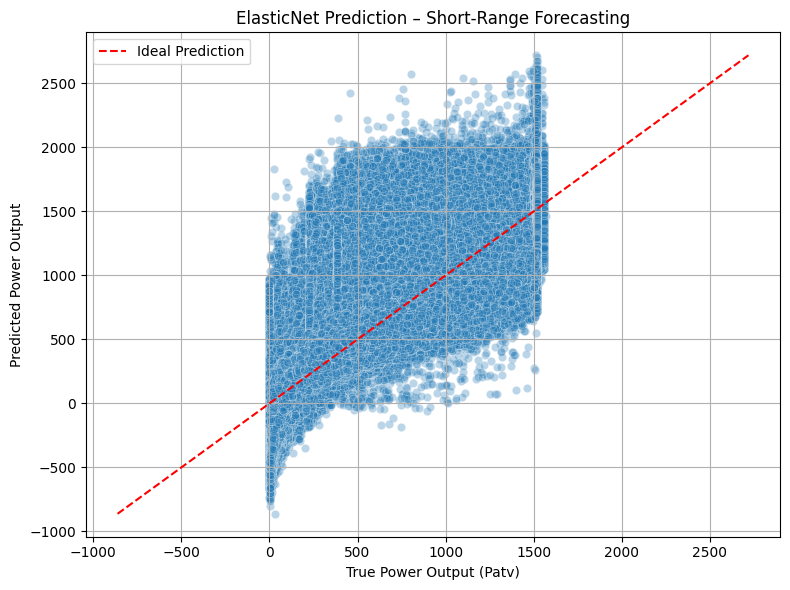

In [ ]:
plt.figure(figsize=(8, 6))

sns.scatterplot(x=y, y=y_pred, alpha=0.3)

max_val = max(y.max(), y_pred.max())
min_val = min(y.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Prediction')

plt.xlabel("True Power Output (Patv)")
plt.ylabel("Predicted Power Output")
plt.title("ElasticNet Prediction – Short-Range Forecasting")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
import joblib

# Assuming 'grid_search' contains the trained ElasticNet pipeline
joblib.dump(grid_search.best_estimator_, "../models/elasticnet_model.joblib")

['../models/elasticnet_model.joblib']

In [35]:
import json

metrics = {
    'best_params': grid_search.best_params_,
    'MAE': round(mae, 2),
    'RMSE': round(rmse, 2),
    'R2': round(r2, 3)
}

with open("../results/elasticnet_scores.json", "w") as f:
    json.dump(metrics, f, indent=4)